# PROGETTO CEREALI COCO
# STEP A

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

### Caricamento modelli

In [2]:
arr_models = ['models/0.jpg', 'models/1.jpg', 'models/11.jpg', 'models/19.jpg', 'models/24.jpg', 'models/25.jpg',
'models/26.jpg']
all_models = {}
all_models_gray = {}

def obt_models(img_models):
    for img in img_models:
        idx_models = int(img.split('/')[1].split('.jpg')[0])
        all_models_gray[idx_models] = cv2.imread(img,0) #to detect keypoints
        all_models[idx_models] =cv2.imread(img)
        #plt.imshow(all_models[idx_models])
        #plt.show()

obt_models(arr_models)

### Cariamento scenari

In [3]:
arr_scenes = ['scenes/e1.png', 'scenes/e2.png', 'scenes/e3.png', 'scenes/e4.png', 'scenes/e5.png']
all_scenes = {}
all_scenes_gray = {}

def obt_scenes(arr_scenes):
    index = 0
    for img in arr_scenes: 
        all_scenes_gray[index] = cv2.imread(img,0) #to detect keypoints
        all_scenes[index] = cv2.imread(img)
        #plt.imshow(all_scenes[index])
        #plt.show()
        index+=1
               
obt_scenes(arr_scenes)

### Creazione SIFT function 
sift.detect() function finds the keypoint in the images. You can pass a mask if you want to search only a part of image. Each keypoint is a special structure which has many attributes like its (x,y) coordinates, size of the meaningful neighbourhood, angle which specifies its orientation, response that specifies strength of keypoints etc.

In [4]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

[ WARN:0] global /Users/runner/work/opencv-python/opencv-python/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (15) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


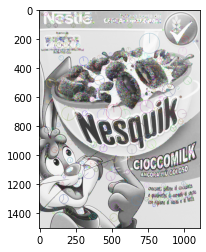

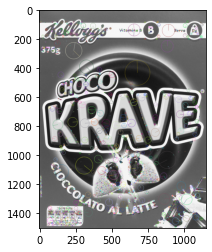

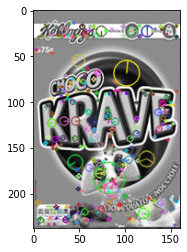

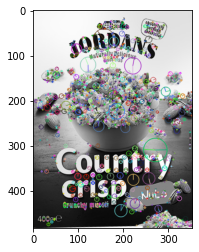

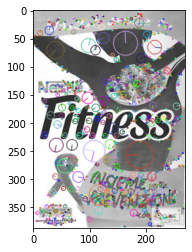

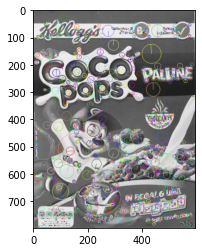

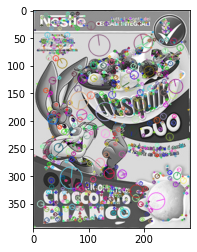

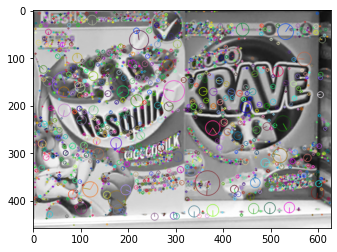

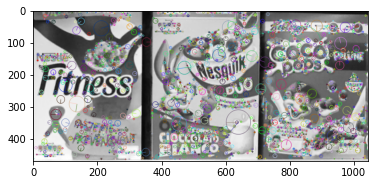

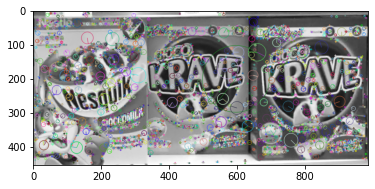

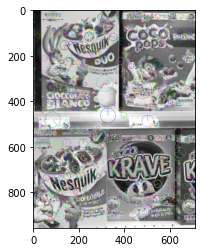

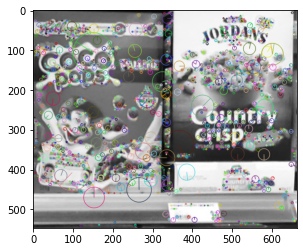

In [5]:
image_dict = {}
models_dict = {}
scenes_dict = {}
description_dict = {}
description_models = []
description_scenes = []


idx_models = ['0', '1', '11', '19','24', '25', '26']

def compute_keypoints(imgs, sift):
    image_dict = {}
    description_dict = {}
    for img in imgs:
        keypoints, descr = sift.detectAndCompute(imgs[img], None)
        description_dict[img] = descr
        image_dict[img] = {'keypoints': keypoints, 'description': descr}
        img_visualization = cv2.drawKeypoints(imgs[img],keypoints,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(img_visualization)
        plt.show()
        
    return image_dict, description_dict

models_dict, description_models = compute_keypoints(all_models_gray, sift)

scenes_dict, description_scenes = compute_keypoints(all_scenes_gray, sift)

### Find matching

In [6]:
def matching(descr_scene, descr_model):

    # Defining index for approximate kdtree algorithm
    FLANN_INDEX_KDTREE = 1 # Defining parameters for algorithm
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)# Matching and finding the 2 closest elements for each query descriptor.
    matches = flann.knnMatch(descr_model, descr_scene, k=2)
    
    return matches

### Trovare i match "buoni"

In [7]:
good = []
def lowe_ratio_test(match_arr, Treshold):
    good = []
    for m,n in match_arr:
        if m.distance < Treshold * n.distance: #  if m.distance/n.distance < Threshold:
            good.append(m)
    return good

#### disegno della maschera

If we are iterating over this list of DMatch objects, then each item will have the following attributes:

item.distance: This attribute gives us the distance between the descriptors. A lower distance indicates a better match.

item.trainIdx: This attribute gives us the index of the descriptor in the list of train descriptors (in our case, it’s the list of descriptors in the img2).

item.queryIdx: This attribute gives us the index of the descriptor in the list of query descriptors (in our case, it’s the list of descriptors in the img1).

item.imgIdx: This attribute gives us the index of the train image.

#### funzione per aggiustare gli angoli

In [10]:
def compute_mask(scene, scene_rgb, all_models, models_dict, kp_s, good_match):
    recognised = {}
    count_model_in_scene = 0 
    thickness = 200
    for model in all_models:
        count_model_in_scene = 0
        kp_m = models_dict[model]['keypoints']
        
        if (good_match[model][0]) > MIN_MATCH_COUNT:

            src_pts = np.float32([ kp_m[m.queryIdx].pt for m in good_match[model][1] ]).reshape(-1,1,2) #src_pts giusti
            dst_pts = np.float32([ kp_s[m.trainIdx].pt for m in good_match[model][1] ]).reshape(-1,1,2) #SONO SBAGLIATI I DISTANCE POINT!

            M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Corners of the query image
            h,w,l = all_models[model].shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            # Projecting the corners into the train image
            dst = cv2.perspectiveTransform(pts,M)

            corners = []
            
            w_scene = scene.shape[1]
            h_scene = scene.shape[0]

            center = tuple((dst[0, 0, i] + dst[1, 0, i] + dst[2, 0, i] + dst[3, 0, i]) / 4 for i in (0, 1))

            x1 = int((dst[0,0,0] + dst[1,0,0]) / 2) if (int((dst[0,0,0] + dst[1,0,0]) / 2) > 0) else 0
            y1 = int((dst[0,0,1] + dst[3,0,1]) / 2) if (int((dst[0,0,1] + dst[3,0,1]) / 2) > 0) else 0
            x2 = int((dst[2,0,0] + dst[3,0,0]) / 2) if (int((dst[2,0,0] + dst[3,0,0]) / 2) < w_scene) else w_scene
            y2 = int((dst[1,0,1] + dst[2,0,1]) / 2) if (int((dst[1,0,1] + dst[2,0,1]) / 2) < h_scene) else h_scene
            
            corners.append(x1)
            corners.append(y1)
            corners.append(x2)
            corners.append(y2)
            
            model_mean_color = all_models[model].mean(axis=0).mean(axis=0)
            
            scene_crop = scene[y1:y2, x1:x2]
            plt.imshow(scene_crop), plt.show();
            scene_mean_color = scene_crop.mean(axis=0).mean(axis=0) 

            val = 0
            for i in abs(model_mean_color - scene_mean_color): 
                val = val+(i**2)
            model_scene_color_diff = np.sqrt(val)
 
            if model_scene_color_diff < COLOR_T :
                for r, corners in recognised.items():
                    r_center = tuple((corners[0, 0, i] + corners[1, 0, i] + corners[2, 0, i] + corners[3, 0, i]) / 4 for i in (0, 1))
                    if (center[0] > min(corners[0, 0, 0], corners[1, 0, 0]) and center[0] < max(corners[2, 0, 0], corners[3, 0, 0])\
                        and center[1] > min(corners[0, 0, 1], corners[3, 0, 1]) and center[1] < max(corners[1, 0, 1], corners[2, 0, 1]))\
                        or (r_center[0] > x1 and r_center[0] < x2 and r_center[1] > y1 and r_center[1] < y2):
                        
                        break

                recognised[model] = dst 
                count_model_in_scene += 1
                
                draw_scene_rgb = cv2.polylines(scene_rgb, [np.int32(recognised[model])], True, (0, 255, 0), 3, cv2.LINE_AA) 
            
            mask_w = int(((dst[3, 0, 0] - dst[0, 0, 0]) + (dst[2, 0, 0] - dst[1, 0, 0])) /2)
            
            mask_h = int(((dst[1, 0, 1] - dst[0, 0, 1]) + (dst[2, 0, 1] - dst[3, 0, 1])) /2)
            
        print('Product {} - {} instance/s found'.format(model, count_model_in_scene))
        
        if(count_model_in_scene > 0):
            center_round = tuple([round(x) if isinstance(x, float) else x for x in center])
            print(' '*3,'Position {}, width: {} px, height: {} px'.format(center_round, mask_w, mask_h))
  
    plt.imshow(draw_scene_rgb), plt.show();
    
    return recognised 

#### funzione


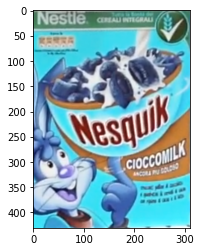

Product 0 - 1 instance/s found
    Position (163, 215), width: 310 px, height: 433 px


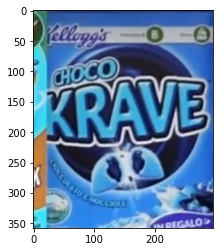

Product 1 - 0 instance/s found


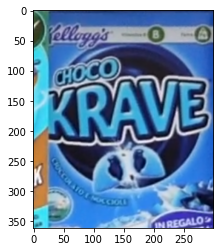

Product 11 - 1 instance/s found
    Position (444, 167), width: 299 px, height: 388 px
Product 19 - 0 instance/s found
Product 24 - 0 instance/s found
Product 25 - 0 instance/s found
Product 26 - 0 instance/s found


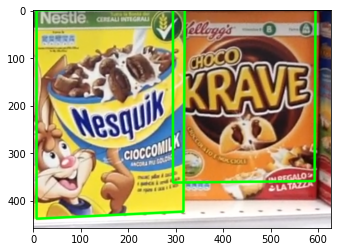

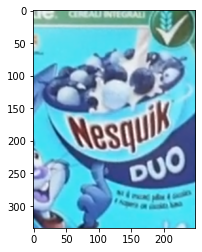

Product 0 - 1 instance/s found
    Position (578, 166), width: 248 px, height: 337 px
Product 1 - 0 instance/s found
Product 11 - 0 instance/s found
Product 19 - 0 instance/s found


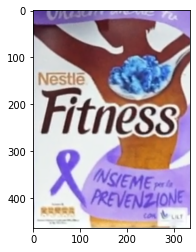

Product 24 - 1 instance/s found
    Position (167, 219), width: 334 px, height: 489 px


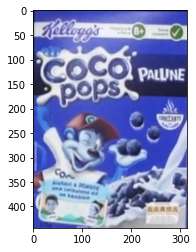

Product 25 - 1 instance/s found
    Position (878, 233), width: 313 px, height: 443 px


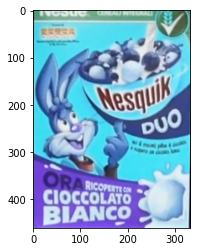

Product 26 - 1 instance/s found
    Position (539, 218), width: 333 px, height: 486 px


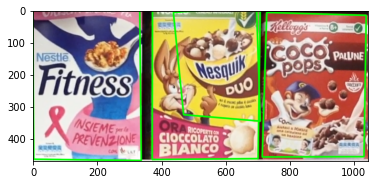

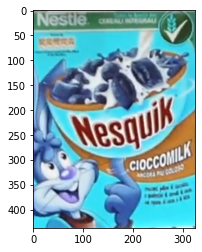

Product 0 - 1 instance/s found
    Position (171, 236), width: 324 px, height: 439 px


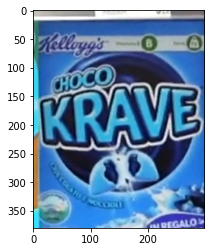

Product 1 - 0 instance/s found


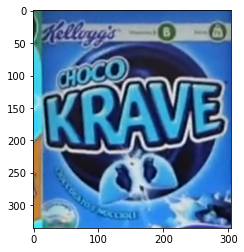

Product 11 - 1 instance/s found
    Position (475, 192), width: 305 px, height: 334 px
Product 19 - 0 instance/s found
Product 24 - 0 instance/s found
Product 25 - 0 instance/s found
Product 26 - 0 instance/s found


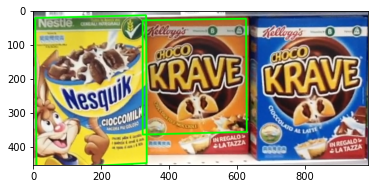

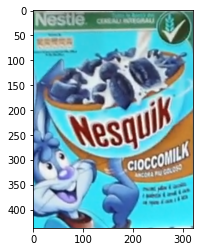

Product 0 - 1 instance/s found
    Position (159, 740), width: 324 px, height: 439 px


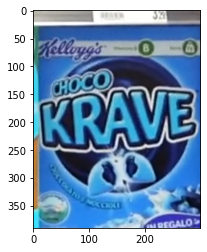

Product 1 - 0 instance/s found


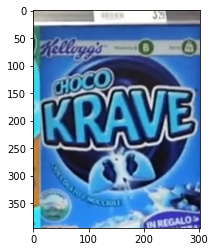

Product 11 - 1 instance/s found
    Position (463, 691), width: 303 px, height: 394 px
Product 19 - 0 instance/s found
Product 24 - 0 instance/s found


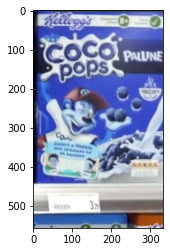

Product 25 - 1 instance/s found
    Position (559, 272), width: 354 px, height: 570 px


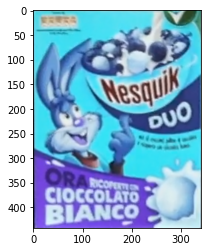

Product 26 - 1 instance/s found
    Position (206, 195), width: 340 px, height: 494 px


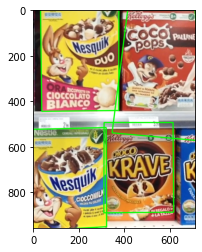

Product 0 - 0 instance/s found
Product 1 - 0 instance/s found
Product 11 - 0 instance/s found


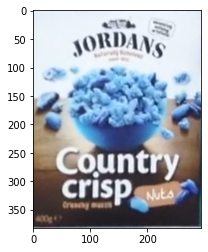

Product 19 - 1 instance/s found
    Position (504, 190), width: 295 px, height: 384 px
Product 24 - 0 instance/s found


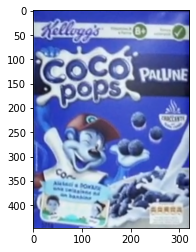

Product 25 - 1 instance/s found
    Position (161, 229), width: 321 px, height: 447 px
Product 26 - 0 instance/s found


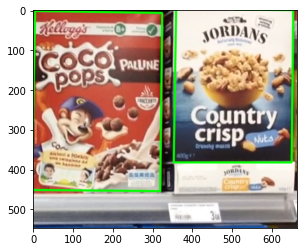

In [11]:
MIN_MATCH_COUNT = 30
MIN_NUM_OF_MATCHES = 15
COLOR_T = 50
# 1. for in cui cicliamo nelle descrizioni dei scenari e poi nelle desc dei modelli
# 2. per ogni ciclo dobbiamo richiamafe la funzione di good e passargli quel determinato scenario e quel det modello
# 3. fare un check se ci sono abbiastanza good matches e richiamre la funzione che disegna la maschera
index_s = 0
index_m = 0
global_matches = {}

for s_descr in description_scenes:
    kp_s = scenes_dict[index_s]['keypoints']
    scene = all_scenes[index_s]
    recognised = {}

    scene_descr = description_scenes[s_descr]
    for m_descr in description_models:

        model_descr = description_models[m_descr]
        model = all_models[m_descr]

        arr_match = matching(scene_descr, model_descr)

        good_match = lowe_ratio_test(arr_match, 0.5)

        global_matches[m_descr] = (len(good_match), good_match)

    scene_img = 'scenes/e' + str(index_s + 1) + '.png'
    r_scene_rgb = cv2.imread(scene_img)
    scene_rgb = cv2.cvtColor(r_scene_rgb, cv2.COLOR_BGR2RGB)
    
    recognised = compute_mask(scene, scene_rgb, all_models, models_dict, kp_s, global_matches)

    index_s += 1